# AdaHessian with Native Fastai Optimizer and No Callback
- With Imagenette and ImageWoof

In [1]:
from fastai.vision.all import *
from fastai.callback.all import *

from AdaHessian import adahessian

In [2]:
def get_path(woof=True):
    if woof: path = untar_data(URLs.IMAGEWOOF_160)
    else: path = untar_data(URLs.IMAGENETTE_160)
    return path

path = get_path(woof=False)
size = 128

In [3]:
def get_dls(size=128):
    dls = ImageDataLoaders.from_folder(path, valid='val', 
        item_tfms=[RandomResizedCrop(size, min_scale=0.35),FlipItem(p=0.5)],  # Resize(size)
        batch_tfms=Normalize.from_stats(*imagenet_stats)) 
    return dls

dls = get_dls(size=size)

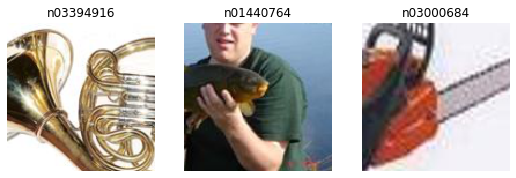

In [4]:
dls.show_batch(max_n=3)

## AdaHessian

@article{yao2020adahessian,
  title={ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning},
  author={Yao, Zhewei and Gholami, Amir and Shen, Sheng and Keutzer, Kurt and Mahoney, Michael W},
  journal={arXiv preprint arXiv:2006.00719},
  year={2020}
}

In [5]:
def average_sqr_diag_hessian(p, sqr_mom, dampening=True, sqr_avg_diag_hessian=None, hutchinson_trace=None, **kwargs):
    if sqr_avg_diag_hessian is None: sqr_avg_diag_hessian = torch.zeros_like(p.grad.data)
    damp = 1-sqr_mom if dampening else 1.
    sqr_avg_diag_hessian.mul_(sqr_mom).addcmul_(hutchinson_trace, hutchinson_trace, value=damp)
    return {'sqr_avg_diag_hessian': sqr_avg_diag_hessian}

In [6]:
def adahessian_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg_diag_hessian, hessian_power, eps, **kwargs):
    "Step for AdaHessian with `lr` on `p`"
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    if hessian_power < 1:
        p.data.addcdiv_(grad_avg, ((sqr_avg_diag_hessian/debias2).sqrt() ** hessian_power) + eps, value = -lr / debias1)  
    else:
        p.data.addcdiv_(grad_avg, (sqr_avg_diag_hessian/debias2).sqrt() + eps, value = -lr / debias1)    
    return p

In [7]:
@log_args(to_return=True, but_as=Optimizer.__init__)
def AdaHessian(params, lr=0.15, hessian_power=1., hutchinson_trace=None, mom=0.9, sqr_mom=0.999, eps=1e-4, wd=1e-4, decouple_wd=True):
    "A `Optimizer` for AdaHessian"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_diag_hessian, step_stat, adahessian_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, hessian_power=hessian_power, eps=eps, wd=wd)


In [8]:
@log_args(but='opt')
class AdaHessianWrapper(Optimizer, GetAttr):
    "Wrap `opt` in a AdaHessian optimizer"
    _default='opt'
    def __init__(self, opt, block_length=32, n_acc=1, fp16=False):
        store_attr(self, 'opt,block_length,n_acc')
        self.acc_count=0
        @patch
        def _backward(self:Learner): self.loss.backward(create_graph=True)
        
    def step(self):
        self._accumulate_grads()
        params, gradsH = self._get_params_grad()
        hvs, v = self._get_hessian(params, gradsH)
        hutchinson_trace = self._get_trace(hvs, v)
        for i, (p,pg,state,hyper) in enumerate(self.opt.all_params(with_grad=True)):
            state['hutchinson_trace'] = hutchinson_trace[i]
            for cb in self.opt.cbs: state = self._update(state, cb(p, **{**state, **hyper}))
            self.opt.state[p] = state
            
    def zero_grad(self):
        self.opt.zero_grad()
            
    def clear_state(self):
        self.opt.clear_state()

    def state_dict(self):
        state = self.opt.state_dict()
        
    def clear_state(self):
        self.opt.clear_state()
    
    def load_state_dict(self, sd):
        self.opt.load_state_dict(sd)
    
    def _accumulate_grads(self):
        self.acc_count += 1
        if self.acc_count < self.n_acc: 
            raise CancelBatchException() #skip weight update
        else: self.acc_count=0
    
    def _get_params_grad(self):
        params, gradsH = [], []
        for p,*_ in self.opt.all_params(with_grad=True):
            params.append(p)
            gradsH.append(0. if p.grad is None else p.grad + 0.)
        return params, gradsH
            
    def _get_hessian(self, params, gradsH):
        device = params[0].device
        v = [torch.randint_like(p, high=2, device=device) for p in params]
        for v_i in v: v_i[v_i == 0] = -1
        hvs = torch.autograd.grad(gradsH, params, grad_outputs=v, only_inputs=True, retain_graph=False)
        return hvs, v
    
    def _get_trace(self, hvs, v):
        hutchinson_trace = []
        for hv, vi in zip(hvs, v):
            param_size = hv.size()

            if len(param_size) <= 1:  
                # For 1D tensor, e.g.,, bias, BatchNorm, LayerNorm etc.
                # Usually, you do not need to set spatial aveging for it, i.e., Hessian diagonal block size is 1 here.
                tmp_output = torch.abs(hv * vi)
                hutchinson_trace.append(tmp_output)

                # Of course, you can also use the same way as 2D tensor does to average your 1D tensor. 
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 2: 
                # For 2D tensor, e.g., the matrix in the fully-connected layer.
                # This is a normal case for MLP, Transformer models. 
                # Usually, a spatial averaging needs to be used here to get the best result.
                # If you are not looking for the absolute best config, you may set it to be 1.
                # In all of our experiments, we sill get pretty good performance.
                tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                hutchinson_trace.append(tmp_output3)
            elif len(param_size) == 3:
                # For 3D tensor, e.g., the 1D Conv layer.
                # This layer is usually used for Char-LM.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 20 and your kernel size is 5, 
                # then the 1D Conv kernel is in size 20x20x5, you can average along the final dim, i.e., the block_length = 5
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2， i.e. the size 5

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 3D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)

            elif len(param_size) == 4:  
                # For 4D tensor, e.g, the 2D Conv layer
                # This layer is usually used for CV tasks.

                # First Way:
                # Usually, you can set it to be the conv kernel size: in more details, for instance, your input/output channels are 256 and your kernel size is 3x3, 
                # then the 2D Conv kernel is in size 20x20x3x3, you can average along the last two dims, , i.e., the block_length = 9
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2, 3], keepdim=True)) / vi[0, 1].numel() # torch.sum() reduces the dim 2/3.
                hutchinson_trace.append(tmp_output)

                # Second way:
                # Of course, you can also use the same self.block_length to average the spatival Hessian of 4D kernel.
                # tmp_output1 = torch.abs((hv * vi + 0.)).view(-1, self.block_length) # faltten to the N times self.block_length
                # tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
                # tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
                # hutchinson_trace.append(tmp_output3)
        return hutchinson_trace
    
    def _update(self, state, new=None):
        if new is None: return state
        if isinstance(new, dict): state.update(new)
        return state

In [9]:
@delegates(AdaHessian)
def adahessian(p, lr=0.15, n_acc=1, block_length=32, hessian_power=1., mom=0.9, sqr_mom=0.999, eps=1e-4, wd=1e-4, **kwargs):
    "Convenience method for `AdaHessianWrapper` with `Adahessian`"
    return AdaHessianWrapper(AdaHessian(p, lr=lr, **kwargs), n_acc=n_acc, block_length=block_length)

## Learn

In [10]:
def get_learn(opt=adahessian, fp16=False):
    if fp16: learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                            loss_func=LabelSmoothingCrossEntropy()).to_native_fp16()
    else: learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                          loss_func=LabelSmoothingCrossEntropy())
    return learn

In [11]:
def run_learn(runs=1, epochs=5, lr=1e-3, opt=adahessian, fp16=False):
    acc_ls=[]
    for i in range(runs):
        print(f'Run {i}')
        learn = get_learn(opt=opt, fp16=fp16)
        learn.fit_one_cycle(epochs, lr)
        acc_ls.append(learn.final_record[2])
    print(f'Mean accuracy for {runs} runs: {np.mean(acc_ls)} ±{np.std(acc_ls)}')

## Ranger

### 5e

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0063095735386013985)

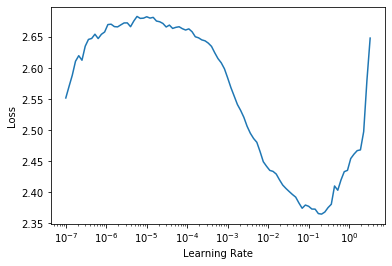

In [13]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=ranger, loss_func=LabelSmoothingCrossEntropy())
learn.lr_find()

In [16]:
run_learn(runs=5, epochs=5, lr=1e-2, opt=ranger)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.740995,2.031312,0.408408,00:10
1,1.499053,1.302378,0.672357,00:10
2,1.266838,1.202228,0.716178,00:10
3,1.098648,1.047301,0.782930,00:10
4,1.003011,1.006701,0.802293,00:10


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.746070,1.979332,0.425223,00:10
1,1.473767,1.365160,0.649172,00:10
2,1.265205,1.286957,0.677707,00:10
3,1.089553,1.024464,0.793885,00:10
4,0.992874,0.984671,0.808408,00:10


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.753583,3.533296,0.309299,00:10
1,1.476711,1.445404,0.612484,00:10
2,1.266907,1.459539,0.609936,00:10
3,1.108794,1.031521,0.785223,00:10
4,1.010697,1.002720,0.796943,00:10


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.727590,1.779038,0.490191,00:10
1,1.495517,1.398286,0.641529,00:10
2,1.281439,1.284866,0.676943,00:10
3,1.099962,1.060967,0.774522,00:10
4,1.003839,1.009763,0.799745,00:10


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.740688,2.206288,0.374777,00:10
1,1.470099,1.309043,0.663440,00:10
2,1.258624,1.419534,0.611465,00:10
3,1.078063,1.040152,0.787006,00:10
4,0.996640,0.993887,0.801529,00:10


Mean accuracy for 5 runs: 0.8017834305763245 ±0.0037892631947342493


In [ ]:
run_learn(runs=3, epochs=20, lr=1e-2, opt=ranger)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.782379,1.614483,0.534268,00:10
1,1.465605,1.331685,0.664204,00:10
2,1.406038,1.915383,0.463694,00:10
3,1.349338,1.230794,0.703439,00:10
4,1.249453,2.392133,0.377325,00:10
5,1.186519,1.065847,0.768408,00:10
6,1.096338,1.317887,0.660127,00:10
7,1.040885,0.989263,0.792866,00:10
8,0.979849,1.207799,0.713631,00:10
9,0.926389,0.974795,0.804076,00:10


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.790362,1.769239,0.468025,00:10
1,1.482998,1.367996,0.643567,00:10
2,1.417471,1.816860,0.494268,00:10


## AdaHessian

In [12]:
opt=adahessian

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.04786301031708717)

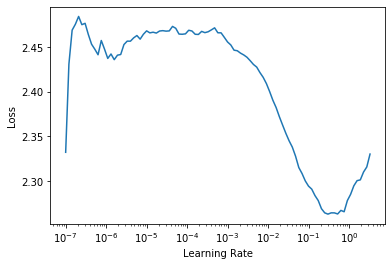

In [13]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, loss_func=LabelSmoothingCrossEntropy())
learn.lr_find()

### 5e

In [14]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=adahessian)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.728154,2.828519,0.352357,00:52
1,1.482394,1.600423,0.546497,00:52
2,1.255046,1.309554,0.671083,00:52
3,1.100562,1.065415,0.773758,00:52
4,1.001062,0.994990,0.802803,00:52


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.762420,2.052577,0.443312,00:52
1,1.472035,1.493609,0.574268,00:52
2,1.268894,1.262720,0.687389,00:52
3,1.112284,1.090453,0.764331,00:52
4,1.011852,1.005748,0.800000,00:52


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.753524,1.774407,0.486879,00:52
1,1.453663,1.597975,0.551338,00:52
2,1.236544,1.284511,0.689172,00:52
3,1.085935,1.073863,0.768917,00:52
4,0.998118,0.996954,0.810191,00:52


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.767347,2.128205,0.403822,00:52
1,1.456279,1.561835,0.567134,00:52
2,1.270548,1.316810,0.662930,00:52
3,1.095388,1.077955,0.770955,00:52
4,1.001607,0.991717,0.808917,00:52


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.725015,3.271604,0.298089,00:52
1,1.444904,1.441231,0.620127,00:52
2,1.246944,1.265659,0.687389,00:52
3,1.095169,1.072511,0.774777,00:53
4,0.997073,0.994787,0.804331,00:52


Mean accuracy for 5 runs: 0.8052484154701233 ±0.0038015651737167253


### 20e

In [15]:
run_learn(runs=5, epochs=20, lr=15e-2, opt=adahessian)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.754759,1.658890,0.520510,00:53
1,1.524924,1.481277,0.602803,00:53
2,1.431160,1.419773,0.629554,00:52
3,1.332326,1.404446,0.625223,00:52
4,1.241525,1.224910,0.694777,00:52
5,1.147733,1.338870,0.653503,00:52
6,1.084003,1.352377,0.674395,00:52
7,1.038003,1.181815,0.723057,00:52
8,0.983402,1.082396,0.763822,00:52
9,0.940595,1.073630,0.762038,00:52


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.741390,1.649466,0.522293,00:53
1,1.533393,1.614468,0.534522,00:53
2,1.408568,1.600239,0.548025,00:53
3,1.340527,1.446098,0.606369,00:53
4,1.228273,1.610818,0.539108,00:53
5,1.142374,1.092102,0.762803,00:52
6,1.083615,1.189811,0.724586,00:52
7,1.055693,1.192096,0.725096,00:52
8,1.009790,1.226865,0.708790,00:52
9,0.966504,1.224157,0.703949,00:52


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.739976,1.763535,0.462166,00:52
1,1.528358,1.838039,0.498344,00:52
2,1.435190,1.439617,0.621656,00:52
3,1.333176,2.410280,0.345223,00:53
4,1.239022,1.369878,0.640764,00:52
5,1.158028,1.330466,0.667771,00:52
6,1.093767,1.390274,0.642038,00:53
7,1.041336,1.361997,0.635414,00:52
8,1.003051,1.070355,0.768408,00:53
9,0.951761,1.069635,0.770701,00:52


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.782587,1.682481,0.514650,00:53
1,1.554693,1.586906,0.565096,00:52
2,1.434846,1.763031,0.508535,00:53
3,1.358597,1.696874,0.535796,00:52
4,1.236027,1.269189,0.692484,00:52
5,1.159858,1.489578,0.593376,00:53
6,1.089476,1.453894,0.623185,00:53
7,1.046833,1.215713,0.704459,00:53
8,0.989945,1.036388,0.782420,00:53
9,0.956209,1.195653,0.718981,00:53


KeyboardInterrupt: 

Only 3 20epoch runs completed:

In [15]:
(88.78 + 88.3 + 88.74)/3

88.60666666666667

## Testing speed impact of Gradient Accumulation

Standard 5 epoch run (no fp16) : **260s**, **80.5%**

Update every 2nd step, 5 epoch run (no fp16) : **250s**

n_acc = 2

In [7]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=partial(adahessian, n_acc=2))

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.707556,2.094579,0.395159,00:50
1,1.488904,1.591411,0.567643,00:50
2,1.271991,1.209190,0.719236,00:49
3,1.148487,1.127175,0.751592,00:50
4,1.060822,1.055177,0.780892,00:50


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.737254,2.019881,0.395924,00:50
1,1.470197,1.619794,0.559745,00:50
2,1.271188,1.244552,0.703185,00:50
3,1.144251,1.093924,0.764586,00:50
4,1.045303,1.048275,0.782930,00:50


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.766291,1.861176,0.450701,00:51
1,1.532242,1.646559,0.555924,00:52
2,1.314764,1.282852,0.675414,00:51
3,1.138932,1.168819,0.726624,00:52
4,1.060984,1.060966,0.777070,00:51


Run 3


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.76 GiB total capacity; 9.36 GiB already allocated; 20.62 MiB free; 9.45 GiB reserved in total by PyTorch)
Exception raised from malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7f1ff073b1e2 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1e64b (0x7f1ff099164b in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1f464 (0x7f1ff0992464 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x1faa1 (0x7f1ff0992aa1 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #4: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x11e (0x7f1f8fd3890e in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xf33949 (0x7f1f8e172949 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf4d777 (0x7f1f8e18c777 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0x10e9c7d (0x7f1fc8f28c7d in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x10e9f97 (0x7f1fc8f28f97 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::empty(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0xfa (0x7f1fc9033a1a in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::fast_set_up(at::TensorIteratorConfig const&) + 0x56a (0x7f1fc8cc0f8a in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::build(at::TensorIteratorConfig&) + 0x76 (0x7f1fc8cc4ff6 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::TensorIterator::TensorIterator(at::TensorIteratorConfig&) + 0xdd (0x7f1fc8cc565d in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x14a (0x7f1fc8cc580a in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x17f5960 (0x7f1f8ea34960 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #15: at::native::threshold_backward_cuda(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x4f (0x7f1f8ea363ef in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0xf242c0 (0x7f1f8e1632c0 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #17: <unknown function> + 0xa9b254 (0x7f1fc88da254 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: at::threshold_backward(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7f1fc900b2a3 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2f1492f (0x7f1fcad5392f in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: <unknown function> + 0xa9b254 (0x7f1fc88da254 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: at::threshold_backward(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7f1fc900b2a3 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::generated::ReluBackward0::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x181 (0x7f1fcab7f3a1 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x3375bb7 (0x7f1fcb1b4bb7 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #24: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7f1fcb1b0400 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f1fcb1b0fa1 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #26: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f1fcb1a9119 in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #27: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f1fdf37bdea in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #28: <unknown function> + 0xc819d (0x7f1ff9f7d19d in /home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #29: <unknown function> + 0x76db (0x7f1ffd2ea6db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #30: clone + 0x3f (0x7f1ffd013a3f in /lib/x86_64-linux-gnu/libc.so.6)


3-run Average

In [8]:
(77.7+78.3+78.)/3

78.0

n_acc = 3

In [9]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=partial(adahessian, n_acc=3))